*Morgan Manning*

*Final Project (Graduate)*

*AI in Biology: Spring 2024*

## Introduction
The Ecuadorian Amazon is home to culturally diverse indigenous communities that interact closely with equally diverse fauna. As part of my dissertation, I am researching the interaction between these communities and the surrounding wildlife populations. Preliminary analysis has been affected by low detection rates among the detected species, resulting in large standard errors and convergence issues. To combat these issues, I will explore the grouping species by functional niche groups and running single-season, grouped species occupancy models to better understand wildlife occupancy surrounding indigenous communities. For this project, I will determine the most suitable number of groups (i.e. clusters). 

The data used for this project is a file containing functional characteristics of each species observed at the study sites (Zábalo, Siekopai, Siona, and Sinangoe) in 2018 and 2020. This data was compiled manually from a variety of animal trait databases, including PanTHERIA, animaldiversity.org, and birdsoftheworld.org (see the spreadsheet for information about specific sources). This data will be used to construct a Gower's Distance matrix, which works well with the primarily categorical data used for this project, to evaluate the functional distance between species. K-means clustering will then be used to group species by functional difference, ideally resulting in functional niche groups that will be used in future occupancy modelling. 


## Data Pre-processing
The functional traits dataset is loaded using the *pandas* package, where functional traits are extracted for clustering. Traits are not standardized or converted to dummy variables because *gower::gower_matrix()* standardizes and converts automatically.

In [19]:
# load necessary packages
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import gower
import seaborn as sns; sns.set()
import numpy as np
from sklearn.metrics import silhouette_score

In [2]:
# load the data into a pandas DataFrame
data = pd.read_csv('speciesAttributesManualInput.csv')
print(data.shape) # 58 species, 19 columns
data.head()

(58, 19)


,Name,Genus,Species,Order,Family,From Pantheria?,ActivityPeriod,APSource,Seasonality,SeasonSource,BodySizeG,BSSource,Locomotion,LocoSource,FeedingHabit,FHSource,FeedingTechnique,FTSource,Notes
0,Atelocynus_microtis,Atelocynus,microtis,Carnivora,Canidae,1,Cathemeral,https://animaldiversity.org/,Resident,https://animaldiversity.org/,9500.0,https://animaldiversity.org/,Terrestrial,https://animaldiversity.org/,Aquatic vertivore,https://animaldiversity.org/,Aquatic surface hunter,https://animaldiversity.org/,NaN
1,Baryphthengus_martii,Baryphthengus,martii,Coraciiformes,Momotidae,0,Diurnal,https://birdsoftheworld.org/,Resident,https://birdsoftheworld.org/,173.0,https://birdsoftheworld.org/,Volant,https://birdsoftheworld.org/,Omnivore,https://birdsoftheworld.org/,Air hunter under canopy,https://birdsoftheworld.org/,NaN
2,Buteogallus_schistaceus,Buteogallus,schistaceus,Accipitriformes,Accipitridae,0,Diurnal,https://birdsoftheworld.org/,Resident,https://birdsoftheworld.org/,455.0,https://birdsoftheworld.org/,Volant,https://birdsoftheworld.org/,Carnivore,https://birdsoftheworld.org/,Air hunter under canopy,https://birdsoftheworld.org/,NaN
3,Cabassous_unicinctus,Cabassous,unicinctus,Cingulata,Dasypodidae,1,Nocturnal,https://doi.org/10.1644/907,Resident,https://doi.org/10.1644/907,2900.0,https://doi.org/10.1644/907,Fossorial,https://doi.org/10.1644/907,Insectivore,https://doi.org/10.1644/907,Underground hunter,https://doi.org/10.1644/907,NaN
4,Canis_lupus,Canis,lupus,Carnivora,Canidae,1,Nocturnal,"(Mayani-Paras, et al. 2023)",Resident,"(Mayani-Paras, et al. 2023)",51500.0,"(Mayani-Paras, et al. 2023)",Terrestrial,"(Mayani-Paras, et al. 2023)",Carnivore,"(Mayani-Paras, et al. 2023)",Ground hunter,"(Mayani-Paras, et al. 2023)",NaN


In [3]:
# select the covariate columns
features = data[['Genus', 'Order', 'Family', 
                 'ActivityPeriod', 'BodySizeG','Locomotion',
                 'FeedingHabit', 'FeedingTechnique']]

# code categorical features
categorical_cols = ['Genus', 'Order', 'Family', 
                 'ActivityPeriod', 'Locomotion', # minus body size
                 'FeedingHabit', 'FeedingTechnique']
features_dummies = pd.get_dummies(features, columns=categorical_cols)

# standardize the data
# features_scaled = StandardScaler().fit_transform(features)


In [4]:
# Create a pairplot
# sns.pairplot(features_dummies)
#plt.show()

## Model Setup
A Gower's Distance matrix is constructed using *gower::gower_matrix()* and k-means clustering is conducted and evaluated with the silhouette score using the *sklearn* package across the range of clusterings. 

In [5]:
# gower dissimilarity
functional_dis = gower.gower_matrix(features)
functional_dis

array([[0.        , 0.88083005, 0.88065374, ..., 0.768127  , 0.7552806 ,
        0.7553287 ],
       [0.88083005, 0.        , 0.50017625, ..., 0.7739571 , 0.75054944,
        0.62550133],
       [0.88065374, 0.50017625, 0.        , ..., 0.77378076, 0.7503732 ,
        0.750325  ],
       ...,
       [0.768127  , 0.7739571 , 0.77378076, ..., 0.        , 0.52340764,
        0.52345574],
       [0.7552806 , 0.75054944, 0.7503732 , ..., 0.52340764, 0.        ,
        0.5000481 ],
       [0.7553287 , 0.62550133, 0.750325  , ..., 0.52345574, 0.5000481 ,
        0.        ]], dtype=float32)

In [6]:
# define the range of cluster numbers to try
n_species = len(data)
cluster_start = 3 # start at 3 because there are three classes (mammals, reptiles, and birds)
cluster_range = range(cluster_start, n_species)

# make a space to store wcss
wcss = []
s_score = []

# loop over the cluster range
for n_clusters in cluster_range:
    # create k-means model
    model = KMeans(n_clusters = n_clusters, random_state = 0, n_init = 15)

    # fit it to the data
    fitted_model = model.fit(functional_dis)
    label = fitted_model.predict(functional_dis)

    # compute the silhouette score and append it to the list
    score = silhouette_score(functional_dis, label)
    s_score.append(score)
    
    # compute the WCSS and append it to the list
    wcss.append(model.inertia_)


## Hyperparameter Tuning
Clustering ranged from 3 (because three were three classes included within the data: mammals, reptiles, and birds) to 58, which was the total number of study species. The Within-Cluster Sum of Squares (WCSS) was evaluated for an "elbow" (i.e. a point at which the rate of decrease sharply changes). To better see this "elbow," I calculated the change in WCSS between cluster sizes (ΔWCSS).

In [7]:
df = pd.DataFrame(wcss, columns = ['WCSS'])
df.insert(loc = 1, column = 'Clusters', value = cluster_range)
# print(df)
df['Difference'] = df['WCSS'].diff()
df.head()

,WCSS,Clusters,Difference
0,59.699142,3,NaN
1,50.219238,4,-9.479904
2,42.884579,5,-7.334660
3,36.422836,6,-6.461742
4,32.925186,7,-3.497650


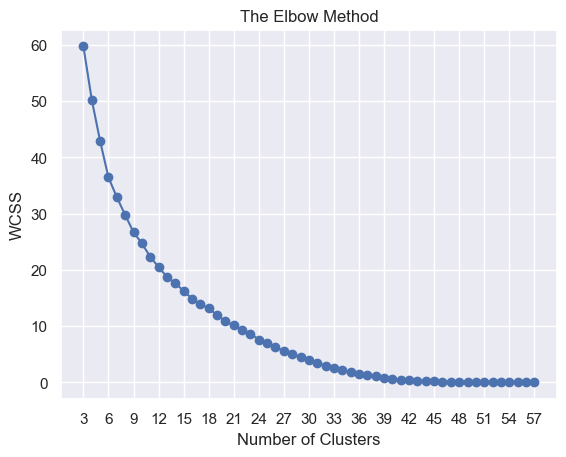

In [15]:
# plot the WCSS values against the cluster range
plt.plot(cluster_range, wcss)
plt.scatter(cluster_range, wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method')
plt.xticks(range(cluster_start, n_species, 3))
plt.show()

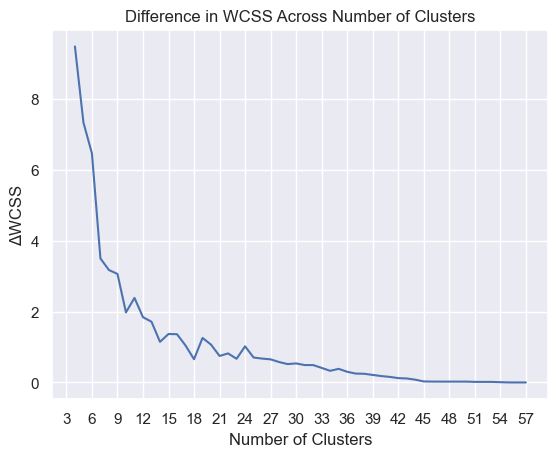

In [9]:
# plot difference in WCSS across the number of clustrs
plt.plot(df['Clusters'], df['Difference'].abs()) # absolute value of the difference
plt.xlabel('Number of Clusters')
plt.ylabel(u'ΔWCSS')
plt.title('Difference in WCSS Across Number of Clusters')
plt.xticks(range(cluster_start, n_species, 3))
plt.show()

## Results
The silhouette score was highest with 24 clusters but was similar and fluctuating between ~16 and ~32 clusters. This is in-line with the smoothing of the ΔWCSS curve at around ~24 clusters. There was no clear best cluster count when looking at the elbow plot, as it was a smooth negative exponential curve. 

In [10]:
s_score_df = pd.DataFrame(s_score, columns = ['Silhouette Score'])
s_score_df.insert(loc = 1, column = 'Clusters', value = cluster_range)
s_score_df.head()

,Silhouette Score,Clusters
0,0.301702,3
1,0.311458,4
2,0.308606,5
3,0.342139,6
4,0.352192,7


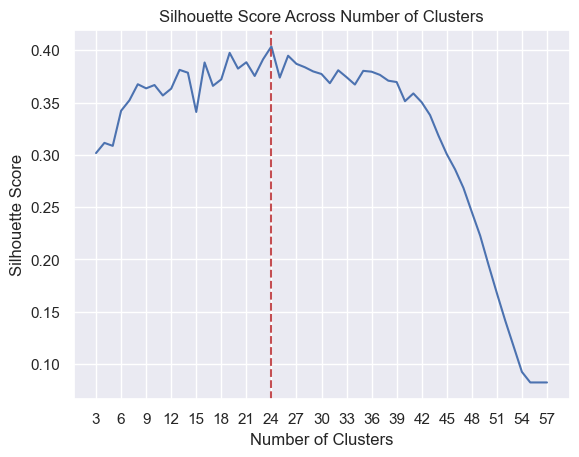

In [11]:
plt.plot(s_score_df['Clusters'], s_score_df['Silhouette Score'])
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Across Number of Clusters')
plt.xticks(range(cluster_start, n_species, 3))
plt.axvline(x = 24, color = 'r', linestyle = 'dashed')
plt.show()

## Discussion
Despite there not being a crystal clear optimal number of clusters, the number of clusters with the highest silhouette score, 24, resulted in all brockets (i.e. Genus *Mazama*) being in the same cluster, which gives proof to the accuracy of the number of clusters. Results from this project will be used in the combining of occupancy detection matrices. Future work could include more functional traits in the traits dataset. 

In [24]:
# 3 clusters
fitted_model_3 = KMeans(n_clusters = 3, random_state = 0, n_init = 15).fit(functional_dis)
species_clustered_3 = pd.DataFrame(fitted_model_3.labels_, columns = ['Cluster'])
species_clustered_3.insert(loc = 0, column = 'Species', value = data[['Name']])
print(species_clustered_3[species_clustered_3['Species'].str.startswith('Mazama')])

# 24 clusters (highest silhouette score)
fitted_model_24 = KMeans(n_clusters = 24, random_state = 0, n_init = 15).fit(functional_dis) 
species_clustered_24 = pd.DataFrame(fitted_model_24.labels_, columns = ['K-means Cluster'])
species_clustered_24.insert(loc = 0, column = 'Species', value = data[['Name']])
print(species_clustered_24[species_clustered_24['Species'].str.startswith('Mazama')])


               Species  Cluster
27    Mazama_americana        0
28  Mazama_gouazoubira        0
29   Mazama_nemorivaga        0
30       Mazama_rufina        0
31          Mazama_sp.        0
               Species  K-means Cluster
27    Mazama_americana                4
28  Mazama_gouazoubira                4
29   Mazama_nemorivaga                4
30       Mazama_rufina                4
31          Mazama_sp.                4


In [30]:
# Create a PAM object with 24 clusters and see what's up with the brockets
kmedoids = KMedoids(n_clusters = 24, random_state = 0).fit(functional_dis)
pam_clustered = pd.DataFrame(kmedoids.labels_, columns = ['PAM Cluster'])
pam_clustered.insert(loc = 0, column = 'Species', value = data[['Name']])
print(pam_clustered[pam_clustered['Species'].str.startswith('Mazama')])


               Species  PAM Cluster
27    Mazama_americana            4
28  Mazama_gouazoubira            4
29   Mazama_nemorivaga            4
30       Mazama_rufina            4
31          Mazama_sp.            4


In [31]:
# combine both types of clustering
pam_clustered.insert(loc = 1, column ='K-Means Cluster', value = species_clustered_24[['K-means Cluster']])
pam_clustered.to_csv('sklearnClusterings.csv', index=False)
pam_clustered

,Species,K-Means Cluster,PAM Cluster
0,Atelocynus_microtis,18,7
1,Baryphthengus_martii,5,23
2,Buteogallus_schistaceus,9,23
3,Cabassous_unicinctus,19,21
4,Canis_lupus,3,19
5,Cebus_albifrons,6,9
6,Cebus_yuracus,20,9
7,Chironectes_minimus,18,20
8,Coendou_longicaudatus,2,22
9,Copeoglossum_nigropunctatum,12,0
